![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

A real estate agency wants us to model the sales price of homes in King County, Washington. They will use our model to help home buyers decide whether homes are underpriced or overpriced. The price of a home can be affected by multiple predictors. We will look at which predictors are statistically significant in terms of affecting a home price. Having a real estate agency use our model will build trust between them and the home buyer. This will likely result in the homebuyer using the same real estate agency if they sell their house in the future.


## Data Understanding

## REVISE LATER THIS WEEK

This data came from Kings County, Washington. It gives us the House Sales for homes in King County, Washington. This will help us model what predicts a sales price for a home buyer. Each data entry represents a house. Our target variable is the price of the home. 

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
 # Basic imports
import numpy as np
import pandas as pd
# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# StatsModel and Metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Install tool to get distance
from geopy import distance

#### Define Utility Function

In [3]:
# # utils.py
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate(y_train, train_preds, y_test, test_preds):
    '''
    Evaluate the amount of error between my model's predictionms and the actual values
    for both a train and a test set
    
    Inputs: 
        y_train - array like, actual values for 'price for my train dataset
        train_preds - array like, predicted values for 'price' for my train dataset
        y_test
        test_preds
    
    Outputs:
        None
    '''
    print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
    print(f"Test R2: {r2_score(y_test, test_preds):.4f}")
    print("*****")
    print(f"Train RMSE: ${mean_squared_error(y_train, train_preds, squared=False):,.2f}")
    print(f"Test RMSE: ${mean_squared_error(y_test, test_preds, squared=False):,.2f}")
    print("*****")
    print(f"Train MAE: ${mean_absolute_error(y_train, train_preds):,.2f}")
    print(f"Test MAE: ${mean_absolute_error(y_test, test_preds):,.2f}")
    print("*****")
    
    # Calculate our residuals 
    train_residuals = y_train - train_preds
    test_residuals = y_test - test_preds
    
    # Scatter plot 
    plt.scatter(train_preds, train_residuals, label = 'Train')
    plt.scatter(test_preds, test_residuals, label = 'Test')
    
    plt.axhline(y=0, color = 'red', label = '0')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.legend()
    
    sm.qqplot(train_residuals, line = 'r', label = 'train residuals');
    plt.legend()
    
    sm.qqplot(test_residuals, line = 'r', label = 'test residuals');
    plt.legend()
    plt.show()
    
    

In [4]:
def next_possible_feature (X_tr, X_te, y_tr, y_te, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. It will
    display a dataframe with a sorted r-squared value.
    X_tr = X_train dataframe
    X_te = X_test dataframe
    y_tr = y_train dataframe
    current_features = list of features that are already in your model
    ignore_features = list of features we know are multicollinear that we want to skip over
    '''
    function_dict = {'predictor': [], 'test r-squared':[]}
    for col in X_tr.columns:
        if col not in (current_features+ignore_features) and X_tr[col].dtypes in ['int64', 'float64']:
            function_X_tr = X_tr[current_features + [col]]
            function_X_te = X_te[current_features + [col]]
            function_model  = sm.OLS(y_tr, sm.add_constant(function_X_tr)).fit()
            function_train_preds = function_model.predict(sm.add_constant(function_X_tr))
            function_test_preds = function_model.predict(sm.add_constant(function_X_te))
            function_dict['predictor'].append(col)
            function_dict['test r-squared'].append(r2_score(y_te, function_test_preds))
    function_df = pd.DataFrame(function_dict).sort_values(by=['test r-squared'], ascending = False)
    display(function_df)

#### Read in Data

In [5]:
!ls data

column_names.md   kc_house_data.csv


In [6]:
# Load Housing Data Set
df = pd.read_csv('data/kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0          5650     1.0        NaN  NONE  ...      7 Average       1180   
1          7242     2.0         NO  NONE  ...      7 Average       2170   
2         10000     1.0         NO  NONE  ...  6 Low Average        770   
3          5000     1.0         NO  NONE  ...      7 Average       1050   
4          8080     1.0         NO  NONE  ...         8 Good       1680   
...         ...     ...        ...   ...  ...            ...        ...   
21592      1131     3.0         NO  NONE  ...         8 Good       1530   
21593      5813     2.0         NO  NONE  ...         8 Good       2310   
21594      1350     2.0         NO  NONE  ...      7 Average       1020   
21595      2388     2.0        NaN  NONE  ...         8 Good       1600   
21596      1076     2.0         NO  NONE  ...      7 Average       1020   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0                0.0     1955           0.0    98178  47.5112 -122.257   
1              400.0     1951        1991.0    98125  47.7210 -122.319   
2                0.0     1933           NaN    98028  47.7379 -122.233   
3              910.0     1965           0.0    98136  47.5208 -122.393   
4                0.0     1987           0.0    98074  47.6168 -122.045   
...              ...      ...           ...      ...      ...      ...   
21592            0.0     2009           0.0    98103  47.6993 -122.346   
21593            0.0     2014           0.0    98146  47.5107 -122.362   
21594            0.0     2009           0.0    98144  47.5944 -122.299   
21595            0.0     2004           0.0    98027  47.5345 -122.069   
21596            0.0     2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [7]:
#Information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [8]:
#Describe the dataframe with descriptive statistics
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  17755.000000   
mean   1.509941e+04      1.494096   1788.596842   1970.999676     83.636778   
std    4.141264e+04      0.539683    827.759761     29.375234    399.946414   
min    5.200000e+02      1.000000    370.000000   1900.000000      0.000000   
25%    5.040000e+03      1.000000   1190.000000   1951.000000      0.000000   
50%    7.618000e+03      1.500000   1560.000000   1975.000000      0.000000   
75%    1.068500e+04      2.000000   2210.000000   1997.000000      0.000000   
max    1.651359e+06      3.500000   9410.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000  
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512  
std       53.513072      0.138552      0.140724     685.230472   27274.441950  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [9]:
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [10]:
df['date'].value_counts()

6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
8/3/2014       1
5/27/2015      1
1/10/2015      1
1/17/2015      1
1/31/2015      1
Name: date, Length: 372, dtype: int64

In [11]:
df['price'].value_counts()

350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64

In [12]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [13]:
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [14]:
#square footage of house living space
df['sqft_living'].value_counts()

1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

In [15]:
#square footage of house lot
df['sqft_lot'].value_counts()

5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

In [16]:
df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [17]:
#does this house have a waterfront?
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [18]:
#how well is the view from the house
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [19]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [20]:
#house grades from poor to mansion
df['grade'].value_counts().sort_index(ascending = False)

9 Better         2615
8 Good           6065
7 Average        8974
6 Low Average    2038
5 Fair            242
4 Low              27
3 Poor              1
13 Mansion         13
12 Luxury          89
11 Excellent      399
10 Very Good     1134
Name: grade, dtype: int64

In [21]:
df['sqft_above'].value_counts()

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

In [22]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
207.0         1
2240.0        1
915.0         1
1990.0        1
283.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [23]:
df['yr_built'].value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [24]:
#year house was renovated, if it was at all
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [25]:
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [26]:
#latitude of house
df['lat'].value_counts()

47.6846    17
47.5322    17
47.6624    17
47.5491    17
47.6886    16
           ..
47.3104     1
47.4681     1
47.2819     1
47.6096     1
47.4300     1
Name: lat, Length: 5033, dtype: int64

In [27]:
#longitude of house
df['long'].value_counts()

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
           ... 
-121.803      1
-121.711      1
-122.454      1
-121.835      1
-121.849      1
Name: long, Length: 751, dtype: int64

In [28]:
#square footage of living space for the 15 closest neighbors
df['sqft_living15'].value_counts()

1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

In [29]:
#square footage of lot space for the 15 closest neighbors
df['sqft_lot15'].value_counts()

5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [30]:
df[df['bedrooms']==33]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors waterfront  view  ...      grade sqft_above  \
15856      6000     1.0         NO  NONE  ...  7 Average       1040   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0     1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

In [31]:
#Replace 33 bedrooms with 3 bedrooms, since 3 is the mean for bedroom count in this dataset
#We suspect this was a typing error when entering the home data
df['bedrooms'].replace(33, 3, inplace=True)

In [32]:
df[df['sqft_basement']=='?']

id        date      price  bedrooms  bathrooms  sqft_living  \
6      1321400060   6/27/2014   257500.0         3       2.25         1715   
18       16000397   12/5/2014   189000.0         2       1.00         1200   
42     7203220400    7/7/2014   861990.0         5       2.75         3595   
79     1531000030   3/23/2015   720000.0         4       2.50         3450   
112    2525310310   9/16/2014   272500.0         3       1.75         1540   
...           ...         ...        ...       ...        ...          ...   
21442  3226049565   7/11/2014   504600.0         5       3.00         2360   
21447  1760650900   7/21/2014   337500.0         4       2.50         2330   
21473  6021503707   1/20/2015   352500.0         2       2.50          980   
21519  2909310100  10/15/2014   332000.0         4       2.50         2380   
21581   191100405   4/21/2015  1580000.0         4       3.25         3410   

       sqft_lot  floors waterfront  view  ...         grade sqft_above  \
6          6819     2.0         NO  NONE  ...     7 Average       1715   
18         9850     1.0         NO  NONE  ...     7 Average       1200   
42         5639     2.0         NO  NONE  ...      9 Better       3595   
79        39683     2.0         NO  NONE  ...  10 Very Good       3450   
112       12600     1.0         NO  NONE  ...     7 Average       1160   
...         ...     ...        ...   ...  ...           ...        ...   
21442      5000     1.0         NO  NONE  ...     7 Average       1390   
21447      4907     2.0         NO  NONE  ...     7 Average       2330   
21473      1010     3.0        NaN  NONE  ...        8 Good        980   
21519      5737     2.0         NO  NONE  ...     7 Average       2380   
21581     10125     2.0         NO  NONE  ...  10 Very Good       3410   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
6                  ?     1995           0.0    98003  47.3097 -122.327   
18                 ?     1921           0.0    98002  47.3089 -122.210   
42                 ?     2014           0.0    98053  47.6848 -122.016   
79                 ?     2002           0.0    98010  47.3420 -122.025   
112                ?     1980           0.0    98038  47.3624 -122.031   
...              ...      ...           ...      ...      ...      ...   
21442              ?     2008           0.0    98103  47.6931 -122.330   
21447              ?     2013           NaN    98042  47.3590 -122.081   
21473              ?     2008           0.0    98117  47.6844 -122.387   
21519              ?     2010           0.0    98023  47.2815 -122.356   
21581              ?     2007           NaN    98040  47.5653 -122.223   

       sqft_living15  sqft_lot15  
6               2238        6819  
18              1060        5095  
42              3625        5639  
79              3350       39750  
112             1540       11656  
...              ...         ...  
21442           2180        5009  
21447           2300        3836  
21473            980        1023  
21519           2380        5396  
21581           2290       10125  

[454 rows x 21 columns]

In [33]:
#Change ? entries for sqft_basement
#This is done by subtracting the sqft_above from sqft_living
df['sqft_basement_diff']= df['sqft_living'] - df['sqft_above']
df.drop('sqft_basement', axis = 1, inplace = True)

#### Check null values in the dataframe

In [34]:
df.isna().sum()

id                       0
date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
waterfront            2376
view                    63
condition                0
grade                    0
sqft_above               0
yr_built                 0
yr_renovated          3842
zipcode                  0
lat                      0
long                     0
sqft_living15            0
sqft_lot15               0
sqft_basement_diff       0
dtype: int64

In [35]:
#Change the entries in waterfront from YES/NO to 1/0
df['waterfront'].replace("YES", 1, inplace=True)
df['waterfront'].replace("NO", 0, inplace=True)
df['waterfront'].fillna(value=0,inplace=True)

In [36]:
#Change the null entries for yr_renovated to 0
df['yr_renovated'].fillna(value=0,inplace=True)

In [37]:
#Change the null values for view to NONE
df['view'].fillna(value='NONE',inplace=True)

In [38]:
#Create a column that with any house that has a view, no matter how well it is
#This essentially is the inverse of the 'view_NONE' column
df['view_YES'] = df['view']
df['view_YES'].replace('NONE', 0, inplace=True)
df['view_YES'].replace('AVERAGE', 1, inplace = True)
df['view_YES'].replace('GOOD', 1, inplace = True)
df['view_YES'].replace('FAIR', 1, inplace = True)
df['view_YES'].replace('EXCELLENT', 1, inplace = True)
df['view_YES'].value_counts()

0    19485
1     2112
Name: view_YES, dtype: int64

In [39]:
#Add a column that calculates the distance from the downtown
distance_data = []
for i in df.index:
    location = (df.loc[i]['lat'],df.loc[i]['long'])
    downtown = (47.6050, -122.3344)
    dist = distance.distance(location, downtown).miles
    distance_data.append(dist)
df['distance'] = distance_data

In [40]:
#for new 'house_age' column:
df['house_age'] = [2016]*len(df['yr_built']) - df['yr_built']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21597 non-null  int64  
 1   date                21597 non-null  object 
 2   price               21597 non-null  float64
 3   bedrooms            21597 non-null  int64  
 4   bathrooms           21597 non-null  float64
 5   sqft_living         21597 non-null  int64  
 6   sqft_lot            21597 non-null  int64  
 7   floors              21597 non-null  float64
 8   waterfront          21597 non-null  float64
 9   view                21597 non-null  object 
 10  condition           21597 non-null  object 
 11  grade               21597 non-null  object 
 12  sqft_above          21597 non-null  int64  
 13  yr_built            21597 non-null  int64  
 14  yr_renovated        21597 non-null  float64
 15  zipcode             21597 non-null  int64  
 16  lat 

In [41]:
df.isna().sum()

id                    0
date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
floors                0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
sqft_basement_diff    0
view_YES              0
distance              0
house_age             0
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21597 non-null  int64  
 1   date                21597 non-null  object 
 2   price               21597 non-null  float64
 3   bedrooms            21597 non-null  int64  
 4   bathrooms           21597 non-null  float64
 5   sqft_living         21597 non-null  int64  
 6   sqft_lot            21597 non-null  int64  
 7   floors              21597 non-null  float64
 8   waterfront          21597 non-null  float64
 9   view                21597 non-null  object 
 10  condition           21597 non-null  object 
 11  grade               21597 non-null  object 
 12  sqft_above          21597 non-null  int64  
 13  yr_built            21597 non-null  int64  
 14  yr_renovated        21597 non-null  float64
 15  zipcode             21597 non-null  int64  
 16  lat 

In [43]:
df.select_dtypes(include = "object")

date  view  condition          grade
0      10/13/2014  NONE    Average      7 Average
1       12/9/2014  NONE    Average      7 Average
2       2/25/2015  NONE    Average  6 Low Average
3       12/9/2014  NONE  Very Good      7 Average
4       2/18/2015  NONE    Average         8 Good
...           ...   ...        ...            ...
21592   5/21/2014  NONE    Average         8 Good
21593   2/23/2015  NONE    Average         8 Good
21594   6/23/2014  NONE    Average      7 Average
21595   1/16/2015  NONE    Average         8 Good
21596  10/15/2014  NONE    Average      7 Average

[21597 rows x 4 columns]

In [44]:
obj_column = [c for c in df.columns if df[c].dtype == 'object']
df[obj_column].describe()

date   view condition      grade
count       21597  21597     21597      21597
unique        372      5         5         11
top     6/23/2014   NONE   Average  7 Average
freq          142  19485     14020       8974

In [45]:
df['grade_int'] = df['grade'].str[:2].astype(int)
df['grade_int'].head(20)

0      7
1      7
2      6
3      7
4      8
5     11
6      7
7      7
8      7
9      7
10     8
11     7
12     7
13     7
14     7
15     9
16     7
17     7
18     7
19     7
Name: grade_int, dtype: int64

In [46]:
# Create a variable for view column
view_col = df[["view"]]
condition_df = df[["condition"]]
#grade_df = df[['grade']]

# Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_view = OneHotEncoder(categories="auto",sparse=False, handle_unknown="ignore")
ohe_cond = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
#ohe_grade = OneHotEncoder(categories = 'auto', sparse=False, handle_unknown ='ignore')

# Fit the encoder on view_col
ohe_view.fit(view_col)
ohe_cond.fit(condition_df)
#ohe_grade.fit(grade_df)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [47]:
# Transform view_col using the encoder and
# assign the result to view_col_encoded
view_col_encoded = ohe_view.transform(view_col)
condition_df_encoded = ohe_cond.transform(condition_df)
#grade_encoded = ohe_grade.transform(grade_df)

In [48]:
# Make the transformed data into a dataframe
view_col_encoded = pd.DataFrame(
    # Pass in NumPy array
    view_col_encoded,
    # Set the column names to the categories found by OHE
    columns="view_"+ohe_view.categories_[0],
    # Set the index to match df's index
    index=df.index
)
condition_df_encoded = pd.DataFrame(
    # Pass in NumPy array
    condition_df_encoded,
    # Set the column names to the categories found by OHE
    columns="cond_"+ohe_cond.categories_[0],
    # Set the index to match df's index
    index=df.index
)
#grade_encoded = pd.DataFrame(grade_encoded,columns="grade_"+ohe_grade.categories_[0],index=df.index)

In [49]:
# Drop original view column
df.drop("view", axis=1, inplace=True)
df.drop("condition", axis=1, inplace=True)
df.drop("grade", axis=1, inplace=True)

# Concatenate the new dataframe with current df
df = pd.concat([df, view_col_encoded, condition_df_encoded], axis=1)
#df = pd.concat([df, view_col_encoded, condition_df_encoded, grade_encoded], axis=1)

# Visually inspect df
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  sqft_above  ...  view_AVERAGE  \
0      5650     1.0         0.0        1180  ...           0.0   
1      7242     2.0         0.0        2170  ...           0.0   
2     10000     1.0         0.0         770  ...           0.0   
3      5000     1.0         0.0        1050  ...           0.0   
4      8080     1.0         0.0        1680  ...           0.0   

   view_EXCELLENT  view_FAIR  view_GOOD  view_NONE  cond_Average  cond_Fair  \
0             0.0        0.0        0.0        1.0           1.0        0.0   
1             0.0        0.0        0.0        1.0           1.0        0.0   
2             0.0        0.0        0.0        1.0           1.0        0.0   
3             0.0        0.0        0.0        1.0           0.0        0.0   
4             0.0        0.0        0.0        1.0           1.0        0.0   

   cond_Good  cond_Poor  cond_Very Good  
0        0.0        0.0             0.0  
1        0.0        0.0             0.0  
2        0.0        0.0             0.0  
3        0.0        0.0             1.0  
4        0.0        0.0             0.0  

[5 rows x 32 columns]

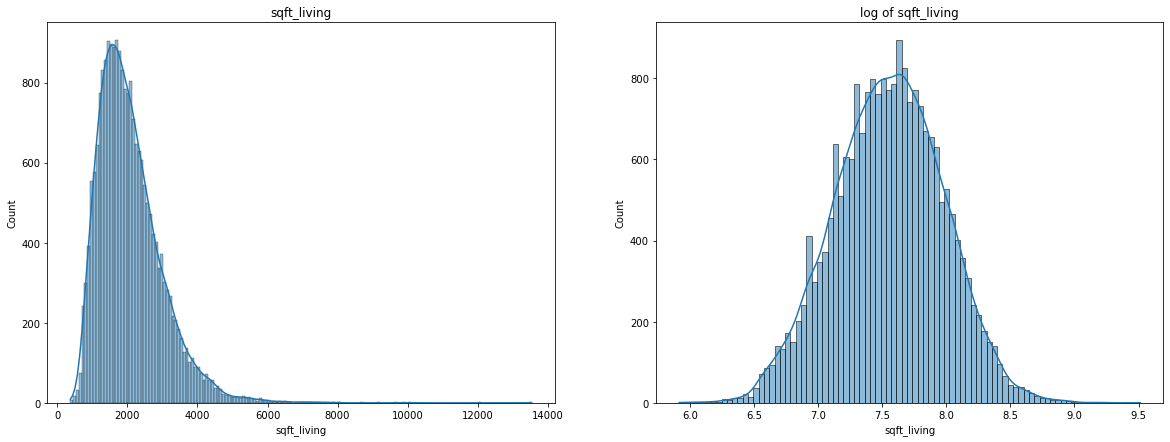

In [50]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('sqft_living')
sns.histplot(df['sqft_living'], kde=True)

plt.subplot(1,2,2)
plt.title('log of sqft_living')
sns.histplot(np.log(df['sqft_living']), kde=True)

plt.show()

In [51]:
#We transformed the sqft_living column because it is heavily skewed
df['logged_sqft_living'] = np.log(df['sqft_living'])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21597 non-null  int64  
 1   date                21597 non-null  object 
 2   price               21597 non-null  float64
 3   bedrooms            21597 non-null  int64  
 4   bathrooms           21597 non-null  float64
 5   sqft_living         21597 non-null  int64  
 6   sqft_lot            21597 non-null  int64  
 7   floors              21597 non-null  float64
 8   waterfront          21597 non-null  float64
 9   sqft_above          21597 non-null  int64  
 10  yr_built            21597 non-null  int64  
 11  yr_renovated        21597 non-null  float64
 12  zipcode             21597 non-null  int64  
 13  lat                 21597 non-null  float64
 14  long                21597 non-null  float64
 15  sqft_living15       21597 non-null  int64  
 16  sqft

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [53]:
X = df.drop(columns=['id', 'price'])
y = df['price']

In [54]:
# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [55]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

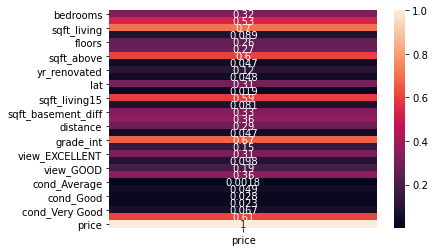

In [56]:
# Absolute value correlations with price
sns.heatmap(abs(train_df.corr())[['price']], annot=True);

In [57]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)

price                 1.000000
sqft_living           0.700397
grade_int             0.671702
logged_sqft_living    0.613274
sqft_above            0.601355
sqft_living15         0.591150
bathrooms             0.529906
view_NONE             0.363970
view_YES              0.363970
sqft_basement_diff    0.328176
bedrooms              0.320253
lat                   0.306659
view_EXCELLENT        0.306340
distance              0.285045
waterfront            0.267665
floors                0.257826
view_GOOD             0.188906
view_AVERAGE          0.146068
yr_renovated          0.116552
view_FAIR             0.097989
sqft_lot              0.089019
sqft_lot15            0.080682
cond_Very Good        0.067110
cond_Fair             0.049162
zipcode               0.047865
house_age             0.046835
yr_built              0.046835
cond_Good             0.027691
cond_Poor             0.022905
long                  0.019459
cond_Average          0.001773
Name: price, dtype: float64

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [58]:
# code here to arrive at a baseline prediction
train_target_mean = y_train.mean()
train_target_mean

541284.4615669568

Train R2: 0.0000
Test R2: -0.0001
*****
Train RMSE: $366,333.44
Test RMSE: $370,425.86
*****
Train MAE: $234,722.63
Test MAE: $233,000.84
*****


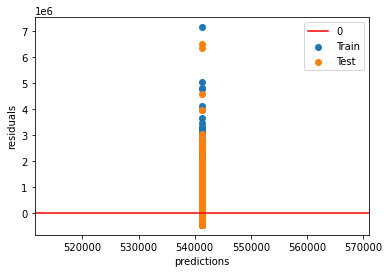

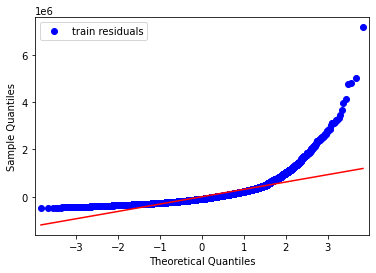

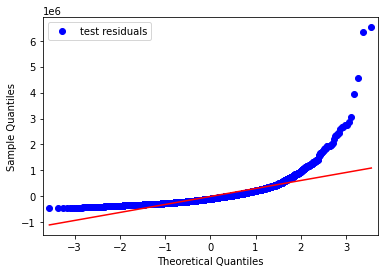

In [59]:
baseline_train_preds = [train_target_mean]*len(y_train)
baseline_test_preds = [train_target_mean]*len(y_test)
evaluate(y_train, baseline_train_preds, y_test, baseline_test_preds)

### First Simple Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [60]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)
#train_df.corr()['price'].sort_values(ascending = False)

price                 1.000000
sqft_living           0.700397
grade_int             0.671702
logged_sqft_living    0.613274
sqft_above            0.601355
sqft_living15         0.591150
bathrooms             0.529906
view_NONE             0.363970
view_YES              0.363970
sqft_basement_diff    0.328176
bedrooms              0.320253
lat                   0.306659
view_EXCELLENT        0.306340
distance              0.285045
waterfront            0.267665
floors                0.257826
view_GOOD             0.188906
view_AVERAGE          0.146068
yr_renovated          0.116552
view_FAIR             0.097989
sqft_lot              0.089019
sqft_lot15            0.080682
cond_Very Good        0.067110
cond_Fair             0.049162
zipcode               0.047865
house_age             0.046835
yr_built              0.046835
cond_Good             0.027691
cond_Poor             0.022905
long                  0.019459
cond_Average          0.001773
Name: price, dtype: float64

In [61]:
# code here for your first 'substandard' model
fsm_X_train= X_train['sqft_living']
fsm_X_test = X_test['sqft_living']
fsm = sm.OLS(y_train, sm.add_constant(fsm_X_train)).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.559e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:17   Log-Likelihood:            -2.2503e+05
No. Observations:               16197   AIC:                         4.501e+05
Df Residuals:                   16195   BIC:                         4.501e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.099e+04   5095.343     -8.044      0.000    -5.1e+04    -3.1e+04
sqft_living   279.4423      2.238    124.878      0.000     275.056     283.828
==============================================================================
Omnibus:                    10430.239   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291279.150
Skew:                           2.656   Prob(JB):                         0.00
Kurtosis:                      23.084   Cond. No.                     5.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.4906
Test R2: 0.4989
*****
Train RMSE: $261,471.87
Test RMSE: $262,216.52
*****
Train MAE: $174,170.69
Test MAE: $171,964.83
*****


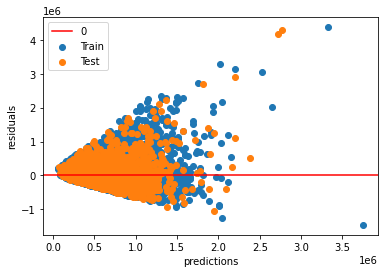

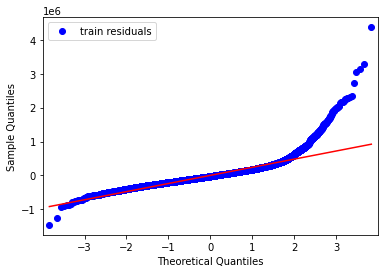

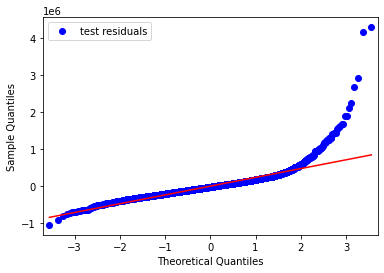

In [62]:
# code here to evaluate your first 'substandard' model
fsm_train_preds = fsm.predict(sm.add_constant(fsm_X_train))
fsm_test_preds = fsm.predict(sm.add_constant(fsm_X_test))

evaluate(y_train, fsm_train_preds, y_test, fsm_test_preds)

#### As seen from the residuals plot above, there is heteroskedasticity problem, which means that the spread of residuals is different at different levels of the fitted values. In order to overcome heteroskedasticity, we can do variable transformation (i.e. log transformation) of the target column.

In [63]:
logged_fsm_y_train= np.log(y_train)
logged_fsm_y_test = np.log(y_test)
fsm_logged = sm.OLS(logged_fsm_y_train, sm.add_constant(fsm_X_train)).fit()
fsm_logged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 1.514e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:18   Log-Likelihood:                -7274.1
No. Observations:               16197   AIC:                         1.455e+04
Df Residuals:                   16195   BIC:                         1.457e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2179      0.007   1653.638      0.000      12.203      12.232
sqft_living     0.0004   3.24e-06    123.040      0.000       0.000       0.000
==============================================================================
Omnibus:                        2.151   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                2.122
Skew:                           0.025   Prob(JB):                        0.346
Kurtosis:                       3.026   Cond. No.                     5.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.4831
Test R2: 0.4836
*****
Train RMSE: $0.38
Test RMSE: $0.38
*****
Train MAE: $0.31
Test MAE: $0.31
*****


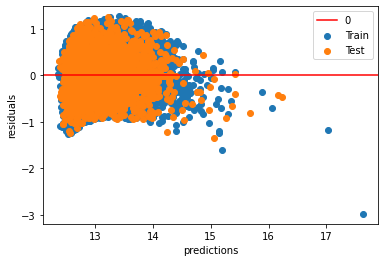

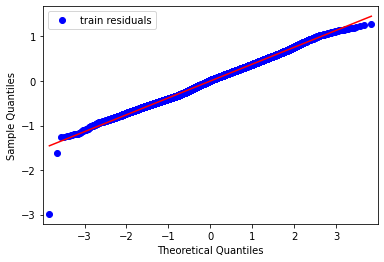

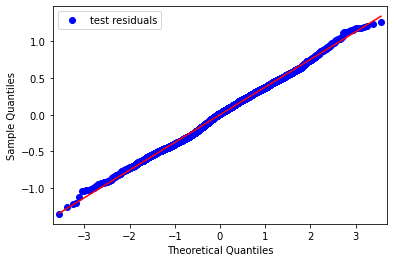

In [64]:
logged_fsm_train_preds = fsm_logged.predict(sm.add_constant(fsm_X_train))
logged_fsm_test_preds = fsm_logged.predict(sm.add_constant(fsm_X_test))

evaluate(logged_fsm_y_train, logged_fsm_train_preds, logged_fsm_y_test, logged_fsm_test_preds)

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [65]:
# code here to iteratively improve your models
selected_features = ['sqft_living']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train,\
                       y_te=logged_fsm_y_test,current_features=selected_features)


predictor  test r-squared
9                  lat        0.658535
15            distance        0.643578
17           grade_int        0.553028
22           view_NONE        0.506047
14            view_YES        0.506047
11       sqft_living15        0.501189
6             yr_built        0.498316
16           house_age        0.498316
10                long        0.497120
19      view_EXCELLENT        0.494059
8              zipcode        0.492269
18        view_AVERAGE        0.490100
0             bedrooms        0.489295
4           waterfront        0.489170
3               floors        0.488352
27      cond_Very Good        0.487403
21           view_GOOD        0.486580
20           view_FAIR        0.486282
7         yr_renovated        0.486274
24           cond_Fair        0.485629
23        cond_Average        0.485554
28  logged_sqft_living        0.485390
1            bathrooms        0.484964
25           cond_Good        0.483977
12          sqft_lot15        0.483968
13  sqft_basement_diff        0.483846
5           sqft_above        0.483846
2             sqft_lot        0.483528
26           cond_Poor        0.482722

#### We noticed that 'distance' and 'lat' had the highest r-squared score when combined with 'sqft_living'. Since 'distance' is dependent on 'lat', we chose 'distance' as our next predictor.

Train R2: 0.6438
Test R2: 0.6436
*****
Train RMSE: $0.31
Test RMSE: $0.31
*****
Train MAE: $0.25
Test MAE: $0.24
*****


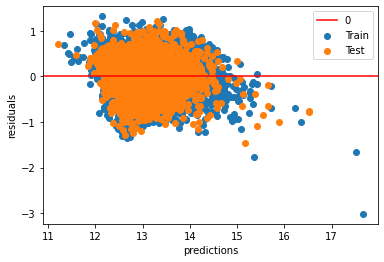

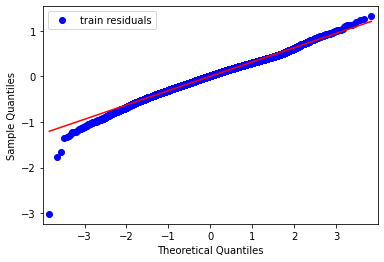

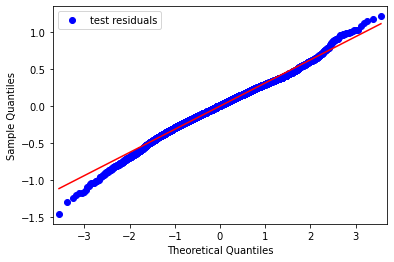

In [66]:
second_predictors = ['sqft_living', 'distance']
second_X_train= X_train[second_predictors]
second_X_test = X_test[second_predictors]
second_model = sm.OLS(logged_fsm_y_train, sm.add_constant(second_X_train)).fit()
second_train_preds = second_model.predict(sm.add_constant(second_X_train))
second_test_preds = second_model.predict(sm.add_constant(second_X_test))
evaluate(logged_fsm_y_train, second_train_preds , logged_fsm_y_test, second_test_preds)

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining an empty dataframe to capture the VIF scores
vif_2 = pd.DataFrame()

# label the scores with their related columns
vif_2["features"] = second_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_2["VIF"] = [variance_inflation_factor(second_X_train.values, i) \
                for i in range(len(second_X_train.columns))]

vif_2

features       VIF
0  sqft_living  2.891538
1     distance  2.891538

### We used VIF to check for Multicollinearity. Since the values are less than 7, they aren't multicollinear.

In [68]:
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 1.463e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:20   Log-Likelihood:                -4260.2
No. Observations:               16197   AIC:                             8526.
Df Residuals:                   16194   BIC:                             8550.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5494      0.007   1728.973      0.000      12.535      12.564
sqft_living     0.0004    2.7e-06    154.350      0.000       0.000       0.000
distance       -0.0320      0.000    -85.447      0.000      -0.033      -0.031
==============================================================================
Omnibus:                      525.446   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              988.590
Skew:                          -0.253   Prob(JB):                    2.14e-215
Kurtosis:                       4.100   Cond. No.                     6.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third iteration with 'sqft_living' and 'distance' as our default predictors

In [69]:
# code here to iteratively improve your models
#latitude and longitude is also selected because we know that distance is dependent on them
selected_features = ['sqft_living','distance']
features_to_ignore = ['lat','long']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)


predictor  test r-squared
14           grade_int        0.698397
9        sqft_living15        0.677814
8              zipcode        0.660283
19           view_NONE        0.654553
12            view_YES        0.654553
11  sqft_basement_diff        0.651814
5           sqft_above        0.651814
25  logged_sqft_living        0.651342
2             sqft_lot        0.651126
10          sqft_lot15        0.650156
16      view_EXCELLENT        0.649365
0             bedrooms        0.647821
1            bathrooms        0.647773
4           waterfront        0.647707
3               floors        0.647299
15        view_AVERAGE        0.646367
18           view_GOOD        0.646074
21           cond_Fair        0.645577
20        cond_Average        0.644550
24      cond_Very Good        0.644374
22           cond_Good        0.644202
17           view_FAIR        0.644003
13           house_age        0.643653
6             yr_built        0.643653
7         yr_renovated        0.643647
23           cond_Poor        0.643181

#### We noticed that 'grade_int' had the highest r-squared score when combined with 'sqft_living' and 'distance'.

In [70]:
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

third_X_train = X_train[['sqft_living', 'distance', 'grade_int']]

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features        VIF
0  sqft_living  10.476382
1     distance   3.787859
2    grade_int  13.698889

In [71]:
third_X_train = X_train[['sqft_living', 'distance', 'sqft_living15']]
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features        VIF
0    sqft_living  14.547911
1       distance   3.433360
2  sqft_living15  17.263409

In [72]:
third_X_train = X_train[['sqft_living', 'distance', 'zipcode']]
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features       VIF
0  sqft_living  6.184608
1     distance  4.044890
2      zipcode  8.598919

### Since 'grade_int', 'sqft_living15', and 'zipcode' have VIF values greater than 7, they are multicollinear. Therefore, we will choose to add 'view_YES' instead

In [73]:
third_X_train = X_train[['sqft_living', 'distance', 'view_YES']]
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features       VIF
0  sqft_living  3.328183
1     distance  2.972410
2     view_YES  1.213542

Train R2: 0.6541
Test R2: 0.6546
*****
Train RMSE: $0.31
Test RMSE: $0.31
*****
Train MAE: $0.24
Test MAE: $0.24
*****


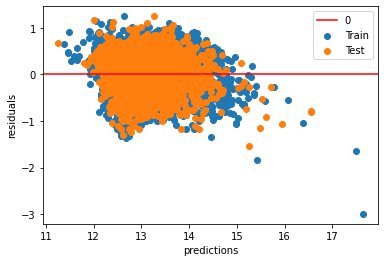

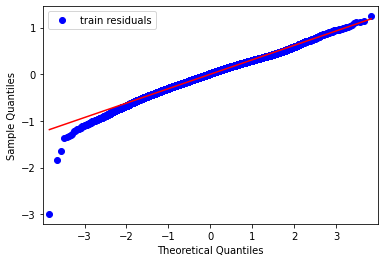

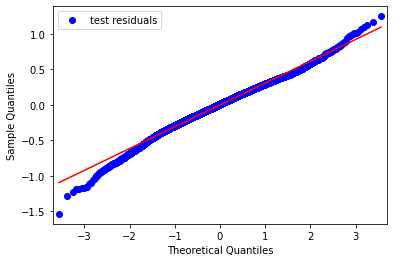

In [74]:
third_predictors = ['sqft_living', 'distance', 'view_YES']
third_X_train= X_train[third_predictors]
third_X_test = X_test[third_predictors]
third_model = sm.OLS(logged_fsm_y_train, sm.add_constant(third_X_train)).fit()
third_train_preds = third_model.predict(sm.add_constant(third_X_train))
third_test_preds = third_model.predict(sm.add_constant(third_X_test))
evaluate(logged_fsm_y_train, third_train_preds , logged_fsm_y_test, third_test_preds)

In [75]:
third_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                 1.021e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:21   Log-Likelihood:                -4022.5
No. Observations:               16197   AIC:                             8053.
Df Residuals:                   16193   BIC:                             8084.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5568      0.007   1753.592      0.000      12.543      12.571
sqft_living     0.0004   2.78e-06    143.702      0.000       0.000       0.000
distance       -0.0311      0.000    -83.585      0.000      -0.032      -0.030
view_YES        0.1901      0.009     21.965      0.000       0.173       0.207
==============================================================================
Omnibus:                      605.841   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.177
Skew:                          -0.323   Prob(JB):                    5.42e-224
Kurtosis:                       4.051   Cond. No.                     8.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fourth Iteration of Model

In [76]:
# code here to iteratively improve your models
#latitude and longitude is selected because we know that distance is dependent on them
#sqft_living15 and grade_int is selcted because we know they wont work from the previous model
selected_features = ['sqft_living','distance', 'view_YES']
features_to_ignore = ['lat', 'long', 'sqft_living15','grade_int', 'zipcode']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)


predictor  test r-squared
9   sqft_basement_diff        0.666507
5           sqft_above        0.666507
21  logged_sqft_living        0.663436
2             sqft_lot        0.661006
8           sqft_lot15        0.660085
3               floors        0.659639
1            bathrooms        0.659102
0             bedrooms        0.657458
17           cond_Fair        0.656508
12      view_EXCELLENT        0.656479
4           waterfront        0.656055
6             yr_built        0.655484
10           house_age        0.655484
20      cond_Very Good        0.655128
16        cond_Average        0.655078
18           cond_Good        0.654910
13           view_FAIR        0.654907
11        view_AVERAGE        0.654651
14           view_GOOD        0.654563
15           view_NONE        0.654553
19           cond_Poor        0.654446
7         yr_renovated        0.654271

In [77]:
# defining an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()

fourth_X_train = X_train[['sqft_living', 'distance', 'view_YES', 'sqft_basement_diff']]

# label the scores with their related columns
vif_4["features"] = fourth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_4["VIF"] = [variance_inflation_factor(fourth_X_train.values, i) \
                for i in range(len(fourth_X_train.columns))]

vif_4

features       VIF
0         sqft_living  4.875723
1            distance  3.217010
2            view_YES  1.242449
3  sqft_basement_diff  1.953062

#### We noticed that 'sqft_basement_diff' had the highest r-squared score when combined with 'sqft_living', 'distance' and 'view_YES'.

Train R2: 0.6661
Test R2: 0.6665
*****
Train RMSE: $0.30
Test RMSE: $0.30
*****
Train MAE: $0.24
Test MAE: $0.24
*****


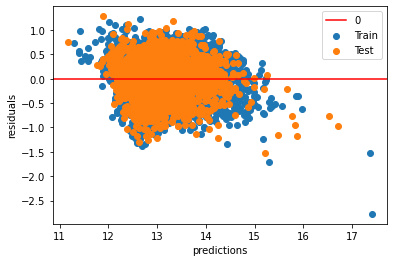

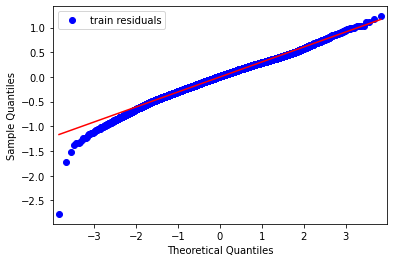

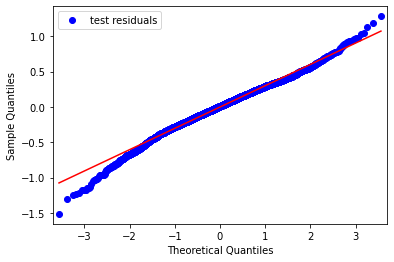

In [78]:
#next we are going to look at waterfront, house_age, and maybe view_NONE
fourth_predictors = ['sqft_living', 'distance', 'view_YES', 'sqft_basement_diff']
fourth_X_train= X_train[fourth_predictors]
fourth_X_test = X_test[fourth_predictors]
fourth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(fourth_X_train)).fit()
fourth_train_preds = fourth_model.predict(sm.add_constant(fourth_X_train))
fourth_test_preds = fourth_model.predict(sm.add_constant(fourth_X_test))
evaluate(logged_fsm_y_train, fourth_train_preds , logged_fsm_y_test, fourth_test_preds)

In [79]:
fourth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     8075.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:22   Log-Likelihood:                -3735.7
No. Observations:               16197   AIC:                             7481.
Df Residuals:                   16192   BIC:                             7520.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5611      0.007   1784.892      0.000      12.547      12.575
sqft_living            0.0004   3.01e-06    142.946      0.000       0.000       0.000
distance              -0.0334      0.000    -88.413      0.000      -0.034      -0.033
view_YES               0.2220      0.009     25.802      0.000       0.205       0.239
sqft_basement_diff    -0.0002    6.3e-06    -24.158      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      559.739   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              919.776
Skew:                          -0.312   Prob(JB):                    1.88e-200
Kurtosis:                       3.987   Cond. No.                     8.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fifth Iteration of Model

In [80]:
# code here to iteratively improve your models
selected_features = ['sqft_living','distance', 'view_YES', 'sqft_basement_diff']
features_to_ignore = ['lat', 'long', 'sqft_living15','grade_int', 'zipcode']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, 
                       ignore_features=features_to_ignore)

predictor  test r-squared
20  logged_sqft_living        0.677138
2             sqft_lot        0.672503
8           sqft_lot15        0.671536
1            bathrooms        0.670097
11      view_EXCELLENT        0.668744
15        cond_Average        0.668624
16           cond_Fair        0.668520
0             bedrooms        0.668364
19      cond_Very Good        0.667980
4           waterfront        0.667864
17           cond_Good        0.667778
10        view_AVERAGE        0.667040
3               floors        0.666935
12           view_FAIR        0.666821
18           cond_Poor        0.666568
13           view_GOOD        0.666560
14           view_NONE        0.666507
5           sqft_above        0.666507
7         yr_renovated        0.666429
6             yr_built        0.666078
9            house_age        0.666078

In [81]:
# defining an empty dataframe to capture the VIF scores
vif_5 = pd.DataFrame()

fifth_X_train = X_train[['sqft_living', 'distance', 'view_YES', 'sqft_basement_diff', 'sqft_lot']]

# label the scores with their related columns
vif_5["features"] = fifth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_5["VIF"] = [variance_inflation_factor(fifth_X_train.values, i) \
                for i in range(len(fifth_X_train.columns))]

vif_5

features       VIF
0         sqft_living  4.897416
1            distance  3.327221
2            view_YES  1.246121
3  sqft_basement_diff  1.953420
4            sqft_lot  1.221673

Train R2: 0.6703
Test R2: 0.6725
*****
Train RMSE: $0.30
Test RMSE: $0.30
*****
Train MAE: $0.24
Test MAE: $0.23
*****


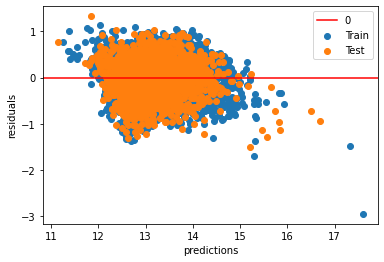

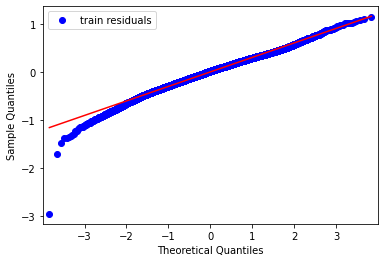

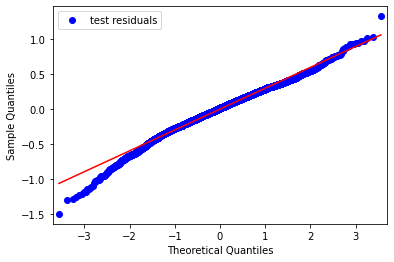

In [82]:
#next we are going to add ''
fifth_predictors = ['sqft_living', 'distance', 'view_YES','sqft_basement_diff', 'sqft_lot']
fifth_X_train= X_train[fifth_predictors]
fifth_X_test = X_test[fifth_predictors]
fifth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(fifth_X_train)).fit()
fifth_train_preds = fifth_model.predict(sm.add_constant(fifth_X_train))
fifth_test_preds = fifth_model.predict(sm.add_constant(fifth_X_test))
evaluate(logged_fsm_y_train, fifth_train_preds , logged_fsm_y_test, fifth_test_preds)

In [83]:
fifth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     6585.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:21:24   Log-Likelihood:                -3632.3
No. Observations:               16197   AIC:                             7277.
Df Residuals:                   16191   BIC:                             7323.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5754      0.007   1780.532      0.000      12.562      12.589
sqft_living            0.0004   3.02e-06    140.399      0.000       0.000       0.000
distance              -0.0346      0.000    -89.928      0.000      -0.035      -0.034
view_YES               0.2161      0.009     25.249      0.000       0.199       0.233
sqft_basement_diff    -0.0002   6.26e-06    -24.166      0.000      -0.000      -0.000
sqft_lot            8.816e-07   6.11e-08     14.427      0.000    7.62e-07       1e-06
==============================================================================
Omnibus:                      711.176   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1261.247
Skew:                          -0.356   Prob(JB):                    1.33e-274
Kurtosis:                       4.167   Cond. No.                     1.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### We found our final 5 predictors. We will see if we can improve our model significantly if we perform a transformation on the predictors.

Train R2: 0.6655
Test R2: 0.6709
*****
Train RMSE: $0.31
Test RMSE: $0.30
*****
Train MAE: $0.24
Test MAE: $0.23
*****


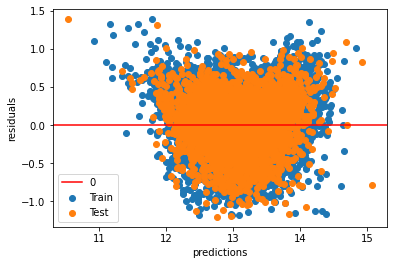

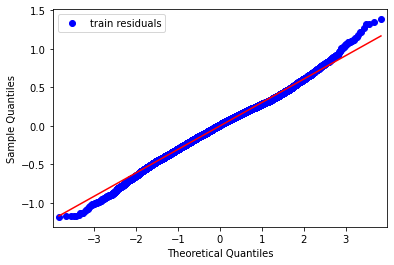

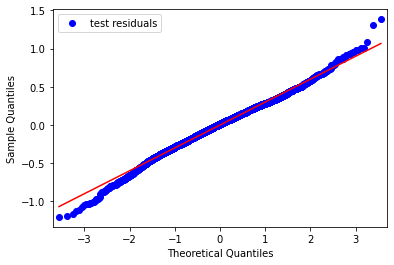

In [84]:
#Let's see if logged_sqft_living has a better effect on the model
sixth_predictors = ['logged_sqft_living', 'distance', 'view_YES','sqft_basement_diff', 'sqft_lot']
sixth_X_train= X_train[sixth_predictors]
sixth_X_test = X_test[sixth_predictors]
sixth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(sixth_X_train)).fit()
sixth_train_preds = sixth_model.predict(sm.add_constant(sixth_X_train))
sixth_test_preds = sixth_model.predict(sm.add_constant(sixth_X_test))
evaluate(logged_fsm_y_train, sixth_train_preds , logged_fsm_y_test, sixth_test_preds)

Train R2: 0.6655
Test R2: 0.6709
*****
Train RMSE: $0.31
Test RMSE: $0.30
*****
Train MAE: $0.24
Test MAE: $0.23
*****


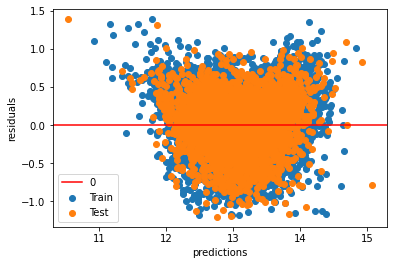

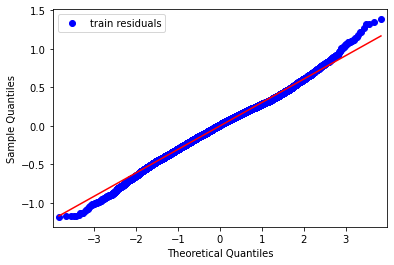

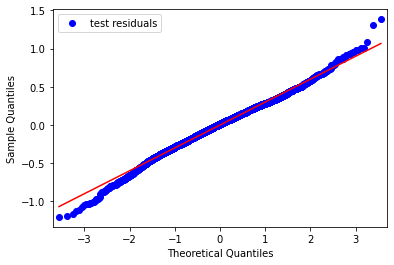

In [85]:
#Let's see if logged_sqft_living has a better effect on the model
sixth_predictors = ['logged_sqft_living', 'distance', 'view_YES','sqft_basement_diff', 'sqft_lot']
sixth_X_train= X_train[sixth_predictors]
sixth_X_test = X_test[sixth_predictors]
sixth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(sixth_X_train)).fit()
sixth_train_preds = sixth_model.predict(sm.add_constant(sixth_X_train))
sixth_test_preds = sixth_model.predict(sm.add_constant(sixth_X_test))
evaluate(logged_fsm_y_train, sixth_train_preds , logged_fsm_y_test, sixth_test_preds)

### Since distance has some outliers past 30 miles, we wanted to test a model that only looks at houses within 30 miles

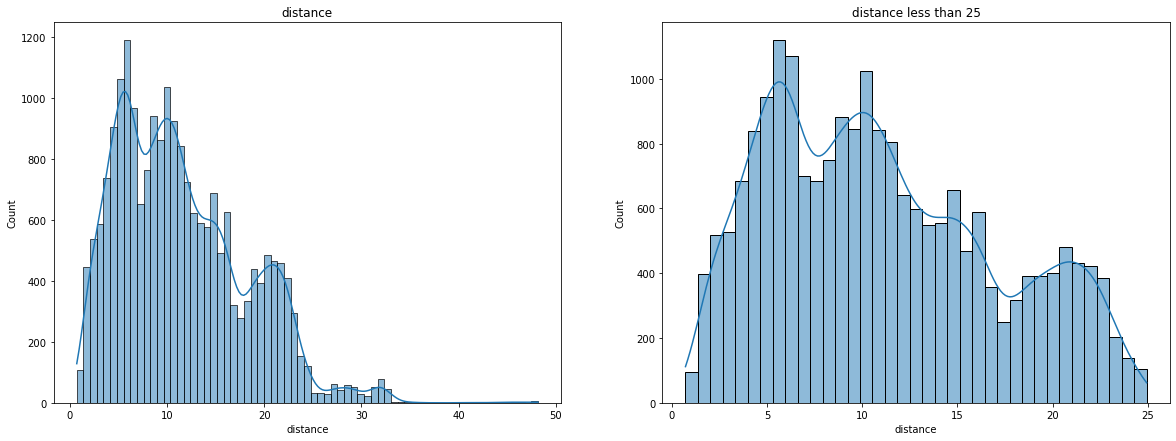

In [86]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('distance')
sns.histplot(df['distance'], kde=True)

plt.subplot(1,2,2)
plt.title('distance less than 25')
sns.histplot(df[df['distance']<25]['distance'], kde=True)

plt.show()

In [87]:
# Import
import plotly.express as px

# Explore relationship between location and price
fig = px.scatter_mapbox(data_frame = train_df, # df name
                        lat='lat', # name of latitude column
                        lon='long', # name of longitude column
                        color='distance', # name of column to use for the color
                        zoom=8)

fig.update_layout(mapbox_style="open-street-map")

In [88]:
ratio_within_25_miles = len(df[df['distance']<25])/len(df['distance'])
ratio_within_25_miles
#97.5 percent of the houses are still being used. 

0.9748113163865352

In [89]:
#Let's do a train/split on the houses within 25 miles
df_distance_25 = df[df['distance']<25]
X_2 = df_distance_25.drop(columns=['id', 'price'])
y_2 = df_distance_25['price']
# Train - Test Split
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)
train_df_2 = pd.concat([X_2_train, y_2_train], axis=1)
test_df_2 = pd.concat([X_2_test, y_2_test], axis=1)
logged_y_2_train= np.log(y_2_train)
logged_y_2_test = np.log(y_2_test)

In [90]:
selected_features = ['sqft_living','distance']
features_to_ignore = ['lat', 'long']
next_possible_feature (X_tr=X_2_train, X_te=X_2_test, y_tr=logged_y_2_train, \
                       y_te=logged_y_2_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)

predictor  test r-squared
14           grade_int        0.716021
9        sqft_living15        0.702482
8              zipcode        0.674986
4           waterfront        0.669232
16      view_EXCELLENT        0.667626
11  sqft_basement_diff        0.666516
5           sqft_above        0.666516
19           view_NONE        0.665350
12            view_YES        0.665350
25  logged_sqft_living        0.664176
0             bedrooms        0.662966
10          sqft_lot15        0.662603
2             sqft_lot        0.662041
3               floors        0.660701
1            bathrooms        0.660232
15        view_AVERAGE        0.659084
24      cond_Very Good        0.659031
7         yr_renovated        0.658973
21           cond_Fair        0.658853
20        cond_Average        0.658813
18           view_GOOD        0.658261
23           cond_Poor        0.658209
22           cond_Good        0.658160
6             yr_built        0.657767
13           house_age        0.657767
17           view_FAIR        0.657094

### Even though 'grade_int', 'sqft_living15', and 'zipcode' have high R-squared values for our filter, we know from an earlier iteration that they are multicollinear. Therefore our next predictor will be 'waterfront' for our filtered dataset

In [91]:
selected_features = ['sqft_living','distance', 'waterfront']
features_to_ignore = ['lat', 'long', 'grade_int', 'sqft_living15', 'zipcode']
next_possible_feature (X_tr=X_2_train, X_te=X_2_test, y_tr=logged_y_2_train, \
                       y_te=logged_y_2_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)

predictor  test r-squared
8   sqft_basement_diff        0.679395
4           sqft_above        0.679395
21  logged_sqft_living        0.676227
7           sqft_lot15        0.673556
0             bedrooms        0.673474
2             sqft_lot        0.673080
15           view_NONE        0.672829
9             view_YES        0.672829
3               floors        0.672552
1            bathrooms        0.672190
12      view_EXCELLENT        0.671441
11        view_AVERAGE        0.670693
20      cond_Very Good        0.670415
17           cond_Fair        0.670411
16        cond_Average        0.670127
6         yr_renovated        0.670066
19           cond_Poor        0.669804
10           house_age        0.669735
5             yr_built        0.669735
14           view_GOOD        0.669627
18           cond_Good        0.669608
13           view_FAIR        0.668614

In [92]:
selected_features = ['sqft_living','distance', 'waterfront', 'sqft_basement_diff']
features_to_ignore = ['lat', 'long', 'grade_int', 'sqft_living15', 'zipcode']
next_possible_feature (X_tr=X_2_train, X_te=X_2_test, y_tr=logged_y_2_train, \
                       y_te=logged_y_2_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)

predictor  test r-squared
20  logged_sqft_living        0.687806
14           view_NONE        0.685174
8             view_YES        0.685174
7           sqft_lot15        0.683730
2             sqft_lot        0.683134
0             bedrooms        0.682487
15        cond_Average        0.682445
11      view_EXCELLENT        0.682349
1            bathrooms        0.681634
19      cond_Very Good        0.681535
10        view_AVERAGE        0.681335
17           cond_Good        0.680989
16           cond_Fair        0.680677
6         yr_renovated        0.680419
13           view_GOOD        0.680411
18           cond_Poor        0.680073
3               floors        0.679417
4           sqft_above        0.679395
5             yr_built        0.679335
9            house_age        0.679335
12           view_FAIR        0.678905

### Since we know from an earlier model that 'logged_sqft_living' is multicollinear, our last predictor will be 'view_YES'. Technically we could use 'view_NONE' but 'view_YES' is a positve correlation instead of a negative correlation

In [93]:
# defining an empty dataframe to capture the VIF scores
vif_7 = pd.DataFrame()

seven_X_train = X_2_train[['sqft_living', 'distance', 'sqft_basement_diff', 'waterfront', 'view_YES']]

# label the scores with their related columns
vif_7["features"] = seven_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_7["VIF"] = [variance_inflation_factor(seven_X_train.values, i) \
                for i in range(len(seven_X_train.columns))]

vif_7

features       VIF
0         sqft_living  5.289567
1            distance  3.536665
2  sqft_basement_diff  1.954941
3          waterfront  1.072635
4            view_YES  1.323466

Train R2: 0.6814
Test R2: 0.6852
*****
Train RMSE: $0.30
Test RMSE: $0.29
*****
Train MAE: $0.23
Test MAE: $0.23
*****


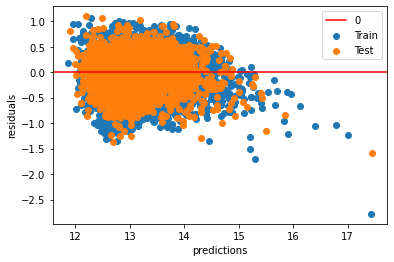

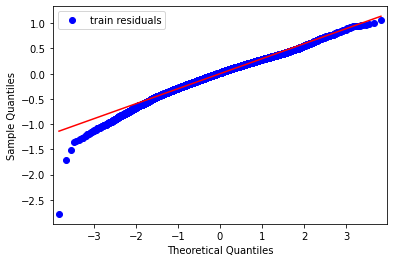

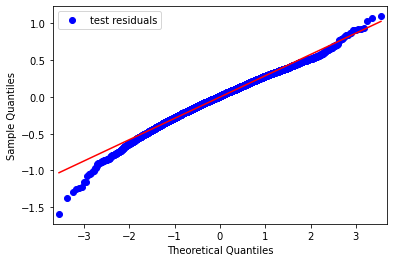

In [94]:
seven_predictors = ['sqft_living', 'distance', 'waterfront','sqft_basement_diff', 'view_YES']
seven_X_train= X_2_train[seven_predictors]
seven_X_test = X_2_test[seven_predictors]
seven_model = sm.OLS(logged_y_2_train, sm.add_constant(seven_X_train)).fit()
seven_train_preds = seven_model.predict(sm.add_constant(seven_X_train))
seven_test_preds = seven_model.predict(sm.add_constant(seven_X_test))
evaluate(logged_y_2_train, seven_train_preds , logged_y_2_test, seven_test_preds)

In [98]:
seven_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     6751.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:31:53   Log-Likelihood:                -3347.9
No. Observations:               15789   AIC:                             6708.
Df Residuals:                   15783   BIC:                             6754.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5881      0.007   1785.233      0.000      12.574      12.602
sqft_living            0.0004      3e-06    147.244      0.000       0.000       0.000
distance              -0.0384      0.000    -91.198      0.000      -0.039      -0.038
waterfront             0.4350      0.030     14.305      0.000       0.375       0.495
sqft_basement_diff    -0.0002   6.25e-06    -26.521      0.000      -0.000      -0.000
view_YES               0.1764      0.009     19.981      0.000       0.159       0.194
==============================================================================
Omnibus:                      889.890   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1482.323
Skew:                          -0.457   Prob(JB):                         0.00
Kurtosis:                       4.190   Cond. No.                     2.95e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
# code here to evaluate your iteration

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [96]:
# code here to show your final model

In [97]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
